<a href="https://colab.research.google.com/github/areejakram24/MY_ProjectsandLabs/blob/main/M2L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Manifold Learning Methods

---



Today, we will be focussing on non-linear dimensionality reduction methods or **Manifold learning** methods.

So a manifold is any space that is locally Euclidean. For example, the Earth is round but it looks flat to us. The Earth is a manifold: locally it is flat, but globally we know it is a sphere. Then, manifold learning performs dimensionality reduction by representing data as low-dimensional manifolds embedded in a higher-dimensional space.

We often suspect that high-dim may actually lie on or near a low-dim manifold (often much lower!) and it would be useful if we could reparametrize the data in terms of this manifold, yielding a low-dim embedding BUT - we typically don’t know the form of this manifold.

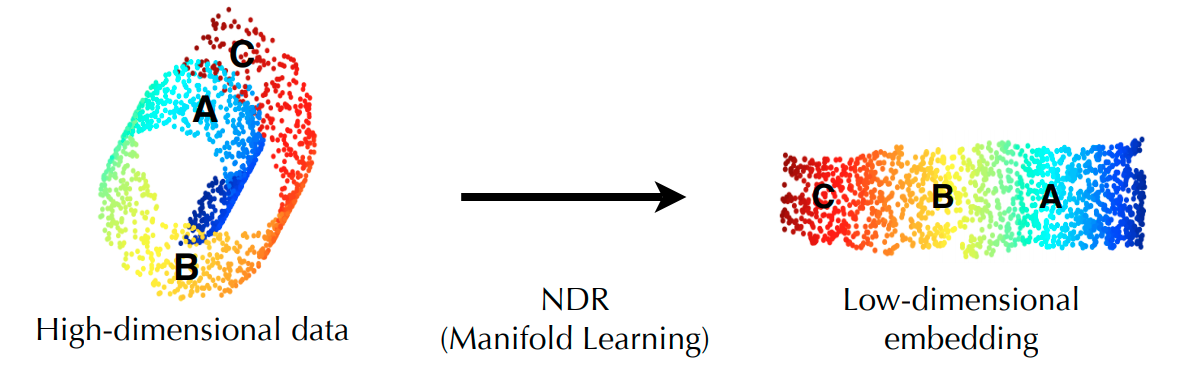

## ISOMAP

---

Isomap stands for **ISOmetric feature MAPping**. Isomap is a non-linear dimensionality reduction method based on the spectral theory which tries to preserve the geodesic distances in the lower dimension.

#### But what are Geodesic Distances?



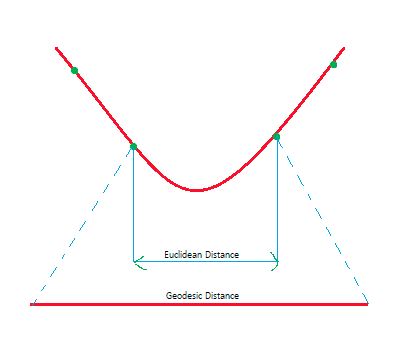

The next question should be:

*How can we compute geodesics without knowing the manifold?* .......
ANSWER: So we build an adjacency graph and approximate geodesic distances by shortest-paths through the graph.


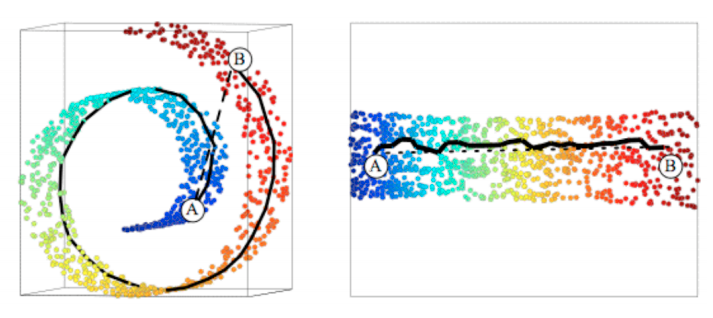

#### 3 steps for ISOMAP:

1. Build the adjacency graph over the points using a Neighbourhood selection method (let's say k nearest neighbours)
2. Compute approximate geodesics: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.
3. Take the top d eigenvectors of the Gram matrix.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

First let us simulate a dataset with the points lying on a manifold which we would want our Isomap to be able to capture.

We will be using the make_s_curve() function in the sklearn.datasets module to make the manifold using 1000 data points

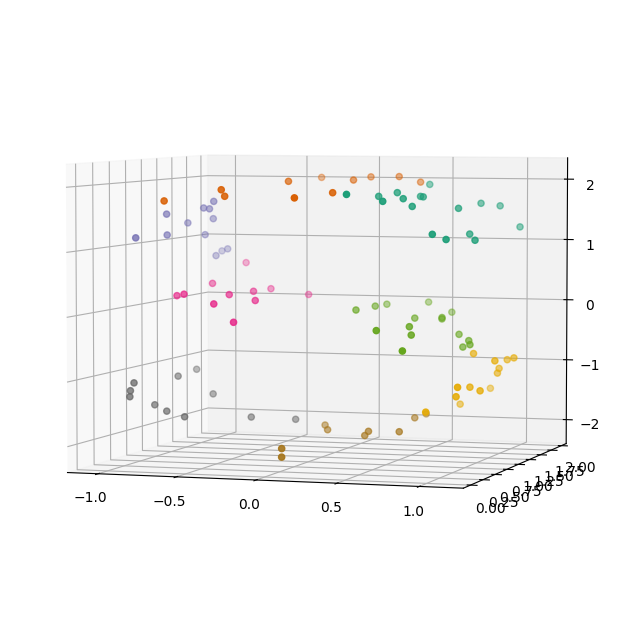

In [4]:
#plotting an s curve
from sklearn.datasets import make_s_curve
X, t = make_s_curve(noise=0.05, random_state=0)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

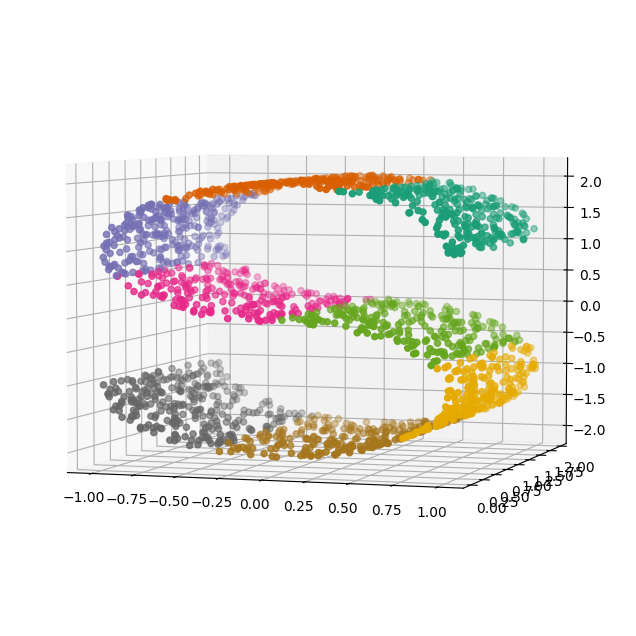

In [5]:
#plotting an s curve
from sklearn.datasets import make_s_curve
samples=2000
X, t = make_s_curve(samples, noise=0.0 ,random_state=0)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

In [ ]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

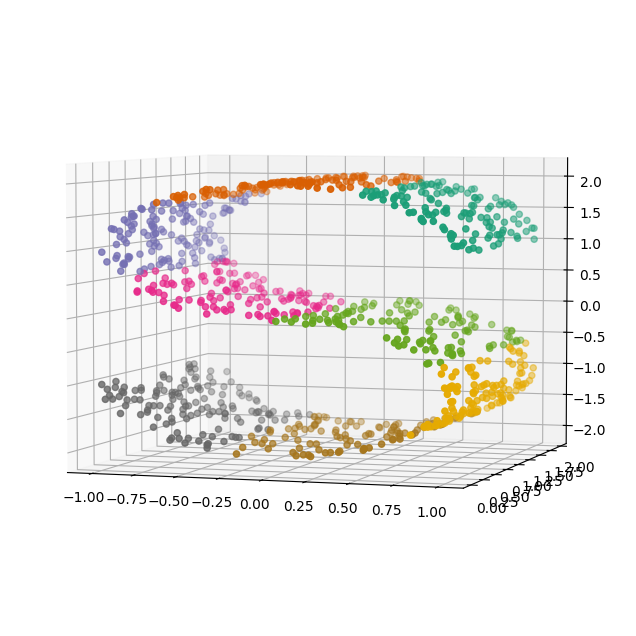

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

In [6]:
#step 1
#pairwise euclidean distances--distance matrix
def dist(a, b):
  d= np.sqrt(sum((a - b) ** 2))
  return d

dist = np.array([[dist(p1, p2) for p2 in X] for p1 in X])
print(dist)

[[0.         1.56351644 0.76526242 ... 0.64304673 0.89950044 1.09823357]
 [1.56351644 0.         1.01508801 ... 1.95042143 1.12672316 1.72207043]
 [0.76526242 1.01508801 0.         ... 1.265306   0.90522789 1.01201169]
 ...
 [0.64304673 1.95042143 1.265306   ... 0.         1.42918308 1.06305902]
 [0.89950044 1.12672316 0.90522789 ... 1.42918308 0.         1.76088859]
 [1.09823357 1.72207043 1.01201169 ... 1.06305902 1.76088859 0.        ]]


In [7]:
print(dist.shape)

(2000, 2000)


In [8]:
#building knn graph adjacency matrix
#keeping 15 nearest neighbours
k = 15
neighbors = np.zeros(dist.shape)
#this matrix contains distances to 15 neighbors only
sort_dist = np.argsort(dist, axis=1)[:, 1:k+1]
for k,i in enumerate(sort_dist):
    neighbors[k,i] = dist[k,i]

In [9]:
neighbors.shape

(2000, 2000)

In [10]:
print(neighbors)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
#step 2
#shortest path between points in graph
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)

In [13]:
#step 3
#gram matrix
gram = (graph ** 2)

In [19]:
#eigen vectors for the matrix

n_samples = gram.shape[0]
meanrows = np.sum(gram, axis=0)/n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]
meanall = meanrows.sum()/n_samples

gram -= meanrows
gram -= meancols
gram += meanall

# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T

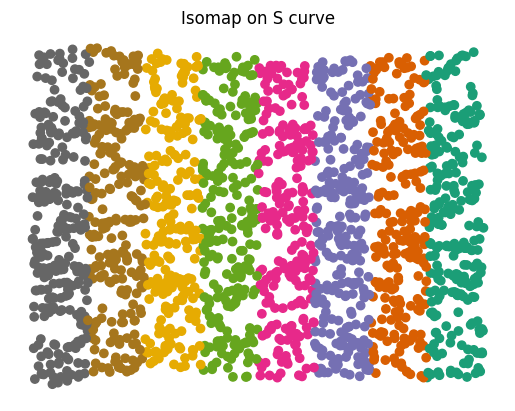

In [21]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=t, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

In [25]:
#or..using predefined library
from sklearn.manifold import Isomap

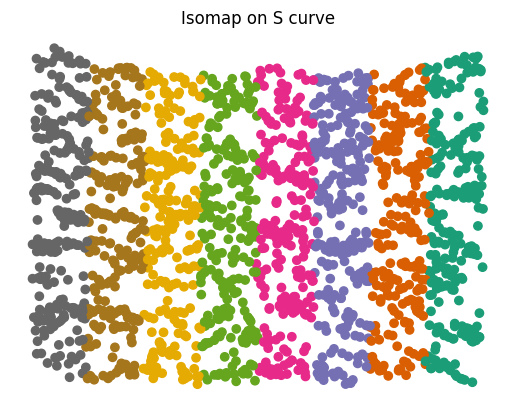

In [23]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=t, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()



---

### Now let us see if Isomap can learn the manifold representation in some more complex datasets

In [27]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

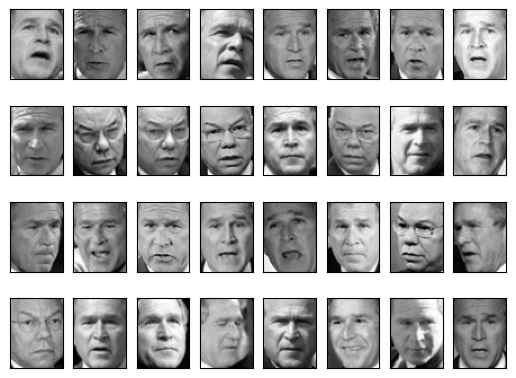

In [28]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

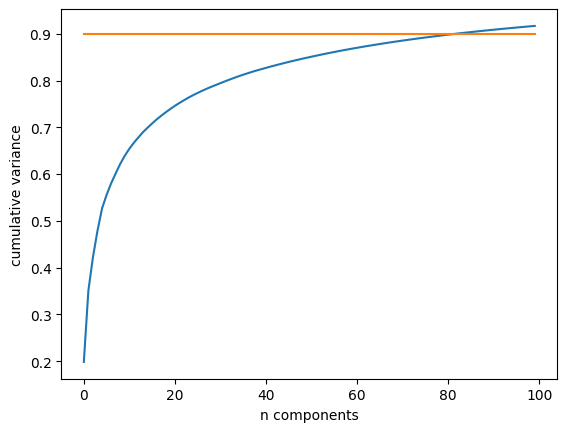

In [29]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

In [30]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

In [31]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

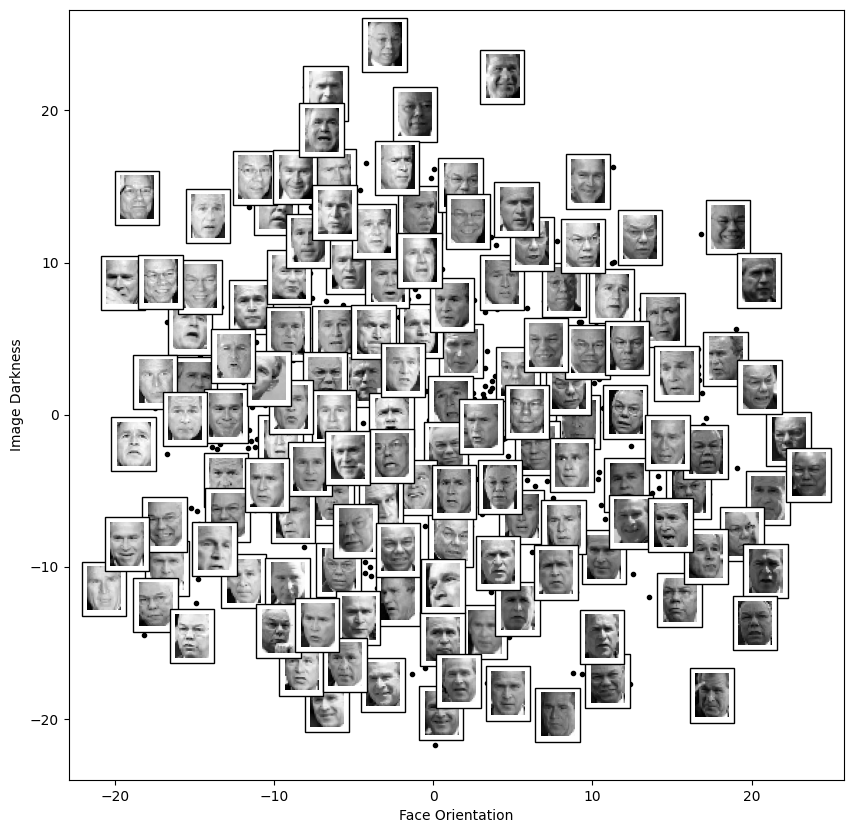

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

Text(0, 0.5, 'Image Darkness')

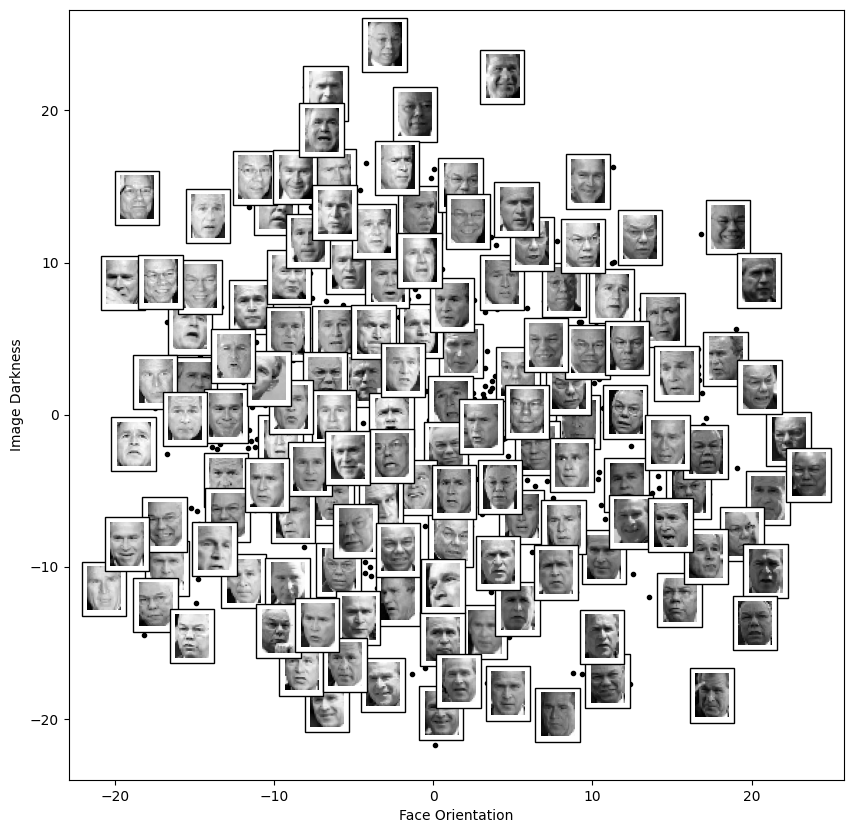

In [35]:
model = Isomap(n_components=2, n_neighbors = 2)
proj = model.fit_transform(faces.data)

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

Text(0, 0.5, 'Image Darkness')

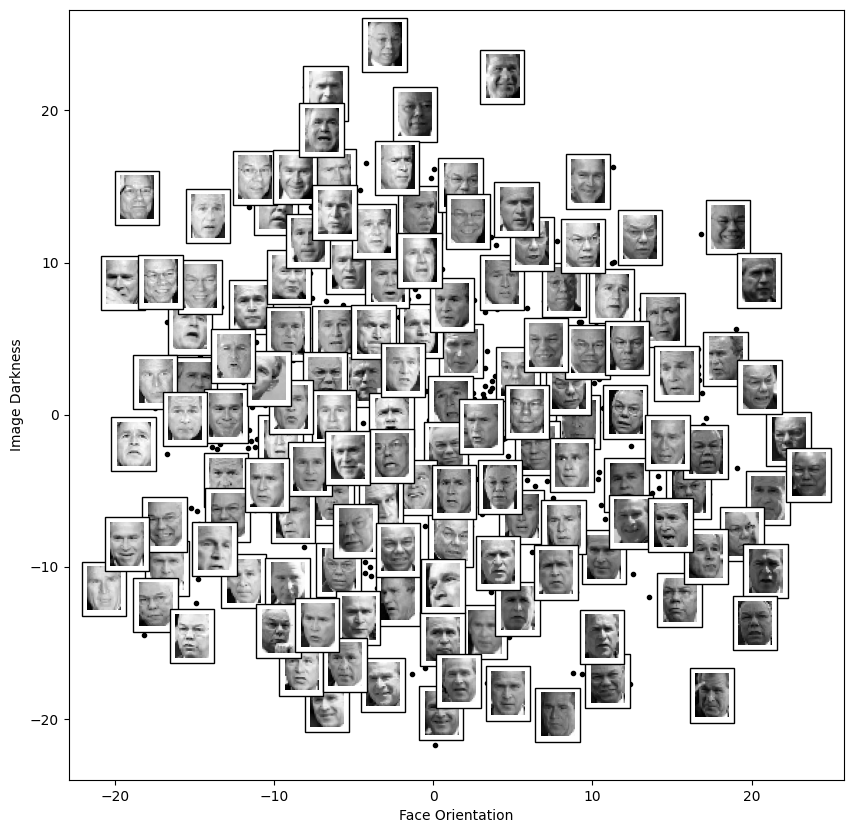

In [36]:
model = Isomap(n_components=2, n_neighbors = 20)
proj = model.fit_transform(faces.data)

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

Text(0, 0.5, 'Image Darkness')

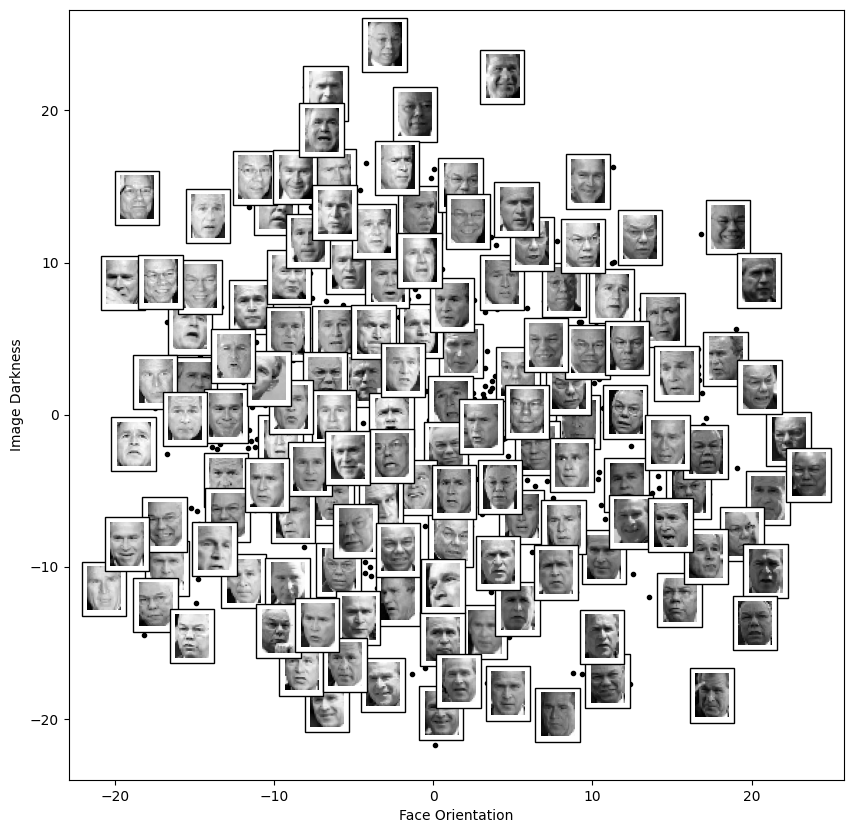

In [37]:
model = Isomap(n_components=2, n_neighbors = 40)
proj = model.fit_transform(faces.data)

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

The isomap is able to capture the underlying manifold but it depends on the number of neighbours we choose.

Text(0, 0.5, 'Image Darkness')

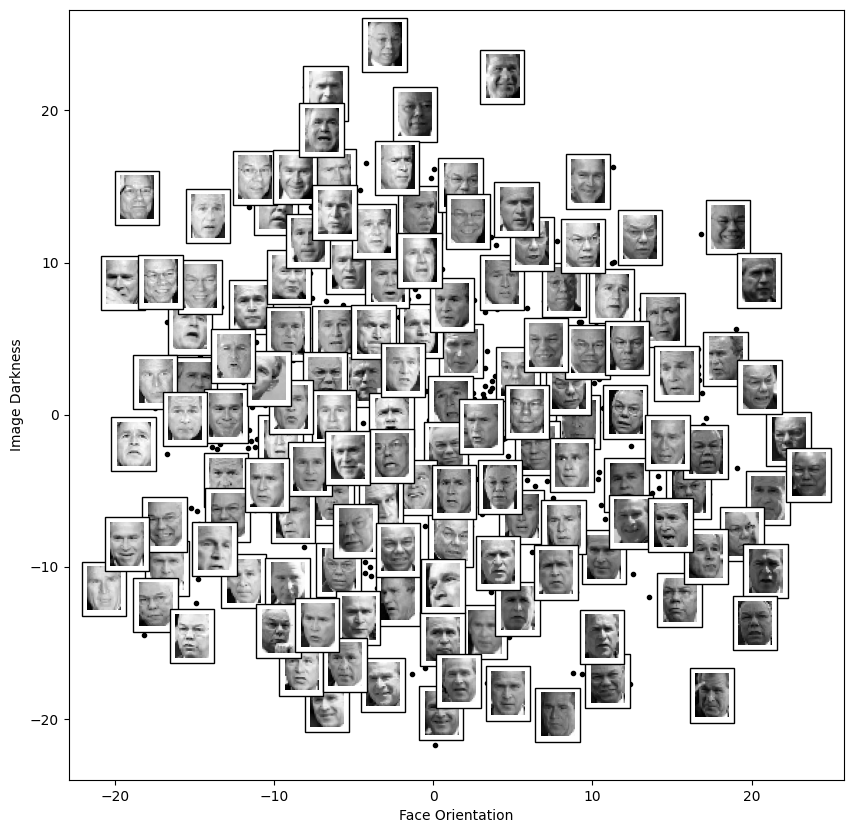

In [38]:
model = Isomap(n_components=2, n_neighbors = 80)
proj = model.fit_transform(faces.data)

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

At first it is hard to understand the variation that much but- each data point only connects to its 2 closest neighbors when we choose 2 neighbors. The results are better for 20 as there is a balance between the local and global structure. For higher n_neighbors the global distances dominate and for smaller n_neighbors local disances dominate. For a smoother pattern an optimal number should be choosen.

Exercises

1. How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?

2. When is the ISOMAP algorithm superior to PCA?

3. Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?

4. Suggest ways to deal with missing data in manifold learning.



1. If the number of neigbors choosen are very high then each data point will have to connect to a huge number of points and that can lead to overfitting. The cmputer tend to igniore the small variation. For less numbers the computer is not properly trained and errors can arise. Each data point connects to only a very small number of neigbors. An appropriate number should be choosen so that each data point is connected to optimal number of data points and model perform well.

2. The isomap algorithm is suitable to use when the data lies in non-linear manifold and more importantly for visualization of the structure. When data is linear PCA workd better.

3. Other manifold learning methods include LLE and t-SNE. Isomap preserves the global distances . It is best when global distances matters. LLE preserves local linear weights. It works in a way such that each data point can be expressed as a combinaition of other data points in a way. TSNE preserves probabilistic similarity i.e, what at=re the neigbors of a data point, like finding closest match for the data point.

4. LLE,TSNE etc work withg complete matrices so any missing data can affect its performance. We can replace missing values with median of the features or use KNN to get a value closest to the neighbors like when samples share similar features it can be used.